# <u>*XGBOOST (Extreme Gradient Boosting)*</u>
This script demonstrates a practical implementation of XGBoost, including hyperparameter tuning and evaluation of different base learner models to identify the best-performing configuration.

This code has been developed following the book: *Hands-On Gradient Boosting with XGBoost and scikit-learn by Corey Wade (Packt Publishing).*


In [35]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score # only used for classification instead  of RMSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # Import r2_score and mean_squared_error
from sklearn.ensemble import RandomForestRegressor # This model works well for non-linear regression problems, and it’s robust to overfitting on large datasets.
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor # Import XGBRFRegressor

# DATA MANAGEMENT

In [36]:
df = pd.read_csv('AAPL.csv', delimiter=';')
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')
df.head()

,Date,PX_LAST,Returns,PX_OPEN,PX_HIGH,PX_LOW,VOLUME,VWAP,VIX,PX_ASK,...,VOLATILITY_90D,Mkt-RF,SMB,HML,RMW,CMA,RF,Price Earnings Ratio (P/E),BEst P/E Ratio,Price/Cash Flow
0,2010-01-04,7.643,0.000000,7.623,7.661,7.585,493728200,7.6314,20.04,7.655,...,25.459,1.69,0.79,1.12,-0.17,0.21,0.0,20.90,23.23,16.04
1,2010-01-05,7.656,0.001701,7.664,7.700,7.616,601904016,7.6657,19.35,7.656,...,25.408,0.31,-0.41,1.24,-0.19,0.19,0.0,20.94,23.27,16.06
2,2010-01-06,7.535,-0.015805,7.656,7.687,7.527,552158376,7.6068,19.16,7.534,...,25.607,0.13,-0.13,0.57,-0.05,0.20,0.0,20.60,22.42,15.81
3,2010-01-07,7.521,-0.001858,7.563,7.571,7.466,477078140,7.5124,19.06,7.519,...,25.515,0.40,0.25,0.98,-0.69,0.22,0.0,20.56,21.74,15.78
4,2010-01-08,7.571,0.006648,7.511,7.571,7.466,447876324,7.5324,18.13,7.571,...,25.289,0.33,0.32,0.01,0.22,-0.37,0.0,20.70,21.88,15.88


In [37]:
# del df['HIST_PUT_IMP_VOL'] -> remove colum
# df = df.rename(columns={"PX_LAST": "Close"}) -> change name of colum
# df['Label'].replace(('s', 'b'), (1, 0), inplace=True) -> this is in case of dummy variable

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3774 non-null   datetime64[ns]
 1   PX_LAST                     3774 non-null   float64       
 2   Returns                     3774 non-null   float64       
 3   PX_OPEN                     3774 non-null   float64       
 4   PX_HIGH                     3774 non-null   float64       
 5   PX_LOW                      3774 non-null   float64       
 6   VOLUME                      3774 non-null   int64         
 7   VWAP                        3774 non-null   float64       
 8   VIX                         3774 non-null   float64       
 9   PX_ASK                      3774 non-null   float64       
 10  PX_BID                      3774 non-null   float64       
 11  SPREAD                      3774 non-null   float64     

All columns are fully populated with numerical data types, making the dataset ready for machine learning applications. We can now proceed with building a regression model.

## Feature Relevance and Redundancy Analysis
Although not specific to XGBoost, this step aims to eliminate irrelevant features in order to reduce noise and improve model performance. For this purpose, we employ two feature selection techniques:
- Correlation analysis
- Mutual informations

Before starting, we need to split the data and identify any irrelevant features that can be removed to improve model performance.
We will analyze the relationships between features using the training set, which comprises 70% of the dataset. The remaining 30% will be evenly split into validation and test sets, each accounting for 15%.


In [39]:
# drop date
df_features = df.drop(['Date'], axis=1)

# Define X and y
X = df_features.drop(columns=['Returns'])  # Features colums: All columns except 'Returns'
y = df_features['Returns']                 # Target column

# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=2)

# Step 2: Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=2)

In [41]:
# Check shapes of the datasets
print("X_train shape:", X_train.shape)  # Expected: (num_train_samples, 60, 3)
print("y_train shape:", y_train.shape)  # Expected: (num_train_samples,)

print("X_val shape:", X_val.shape)      # Expected: (num_val_samples, 60, 3)
print("y_val shape:", y_val.shape)      # Expected: (num_val_samples,)

print("X_test shape:", X_test.shape)    # Expected: (num_test_samples, 60, 3)
print("y_test shape:", y_test.shape)    # Expected: (num_test_samples,)


X_train shape: (2641, 23)
y_train shape: (2641,)
X_val shape: (566, 23)
y_val shape: (566,)
X_test shape: (567, 23)
y_test shape: (567,)


In [42]:
# Check if total samples match original dataset
total_split_samples = len(X_train) + len(X_val) + len(X_test)
original_samples = df.shape[0]

print("Total split samples:", total_split_samples)
print("Original dataset samples:", original_samples)
print("Match:", total_split_samples == original_samples)


Total split samples: 3774
Original dataset samples: 3774
Match: True


### *Correlation analysis:*
Correlation is not a big problem, but dropping some can improve efficiency, speed and interpretability.

In [43]:
print(X_train.shape)
print(y_train.shape)

(2641, 23)
(2641,)


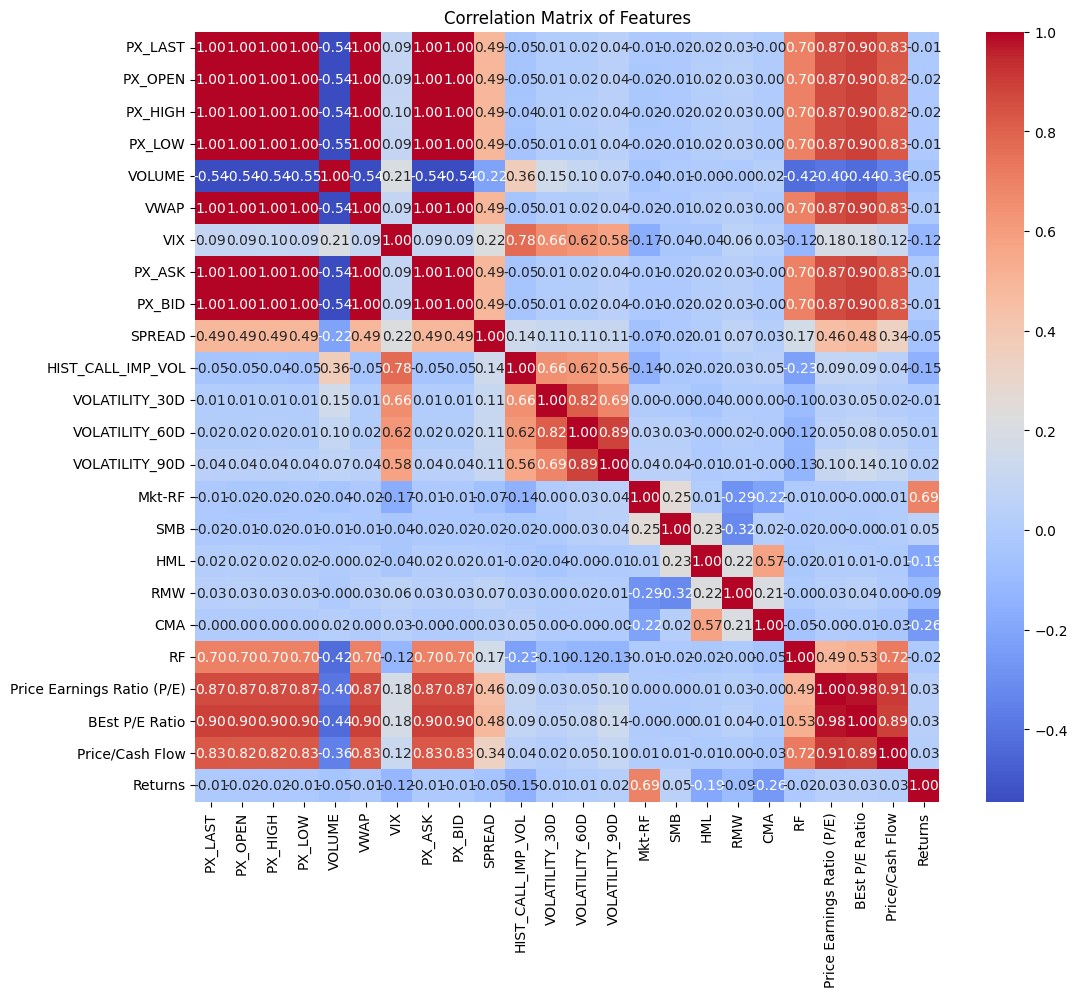

In [44]:
# Combine features and target into one DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# Unstack the correlation matrix and sort the values
stacked_corr = corr_matrix.unstack()
sorted_corr = stacked_corr.sort_values(ascending=False)

# Remove self-correlations
sorted_corr = sorted_corr[sorted_corr != 1]

# Get the top correlated pairs (you can adjust the number as needed)
top_correlated = sorted_corr.head(20)  # Get the top 20 pairs

print("Top 20 Most Correlated Feature Pairs:")
top_correlated

Top 20 Most Correlated Feature Pairs:


PX_BID   PX_ASK     1.000000
PX_ASK   PX_BID     1.000000
PX_BID   PX_LAST    0.999997
PX_LAST  PX_BID     0.999997
         PX_ASK     0.999997
PX_ASK   PX_LAST    0.999997
PX_HIGH  VWAP       0.999904
VWAP     PX_HIGH    0.999904
         PX_LOW     0.999903
PX_LOW   VWAP       0.999903
PX_LAST  VWAP       0.999895
VWAP     PX_LAST    0.999895
PX_ASK   VWAP       0.999895
VWAP     PX_ASK     0.999895
PX_BID   VWAP       0.999894
VWAP     PX_BID     0.999894
PX_OPEN  VWAP       0.999831
VWAP     PX_OPEN    0.999831
PX_OPEN  PX_HIGH    0.999802
PX_HIGH  PX_OPEN    0.999802
dtype: float64

In [45]:
def get_highly_correlated_features(df, threshold=0.9):
    # Compute absolute correlation matrix
    corr_matrix = df.corr().abs()

    # Keep upper triangle of the matrix (excluding self-correlations)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify features to consider for removal
    features_to_remove = set()
    for column in upper.columns:
        high_corr_features = upper.index[upper[column] > threshold].tolist()
        if high_corr_features:
            features_to_remove.add(column)

    return sorted(features_to_remove)

# Example usage:
features_to_remove = get_highly_correlated_features(X_train, threshold=0.9)

print("Features to consider removing due to high correlation:")
print(features_to_remove)

Features to consider removing due to high correlation:
['BEst P/E Ratio', 'PX_ASK', 'PX_BID', 'PX_HIGH', 'PX_LOW', 'PX_OPEN', 'Price/Cash Flow', 'VWAP']


Remove the most correlated features:

In [46]:
# List of features to remove
features_to_drop = ['PX_BID', 'PX_ASK']

# Drop them from all feature sets
X_train = X_train.drop(columns=features_to_drop)
X_val = X_val.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [47]:
# Verify that the specified columns have been successfully removed
print("---------------------------------------")
print("Shape:", X_train.shape)
print("---------------------------------------")

X_train.head(1)

---------------------------------------
Shape: (2641, 21)
---------------------------------------


,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,VOLUME,VWAP,VIX,SPREAD,HIST_CALL_IMP_VOL,VOLATILITY_30D,...,VOLATILITY_90D,Mkt-RF,SMB,HML,RMW,CMA,RF,Price Earnings Ratio (P/E),BEst P/E Ratio,Price/Cash Flow
1664,27.045,26.945,27.11,26.945,74641736,27.0321,11.55,0.002,17.642,23.16,...,24.054,-0.06,0.14,-0.17,-0.14,-0.28,0.001,12.7,13.1,9.5


### *Mutual Information:*
Mutual information (MI) is a statistical measure that quantifies the dependency between two random variables by assessing how much knowledge of one reduces the uncertainty about the other. It is a dimensionless quantity, typically expressed in bits. A high MI value indicates a strong relationship, while MI equal to zero implies independence. *Reference:* Latham, P. E., & Roudi, Y. (2009). *Mutual Information*. Scholarpedia, 4(1):1658. Available at: [http://www.scholarpedia.org/article/Mutual_information](http://www.scholarpedia.org/article/Mutual_information)  

In the context of machine learning, mutual information is often used for feature selection, as it helps evaluate how informative a feature is with respect to the target variable. Features with high MI scores are likely to contribute meaningfully to the model, whereas those with very low or zero MI are generally irrelevant and can be removed to improve efficiency and reduce noise.

Mutual Information Scores:
Mkt-RF                        0.328635
HIST_CALL_IMP_VOL             0.094153
VIX                           0.053152
VOLATILITY_30D                0.049419
CMA                           0.044523
VOLUME                        0.039889
VOLATILITY_60D                0.034913
VOLATILITY_90D                0.033405
BEst P/E Ratio                0.030451
HML                           0.029979
PX_LAST                       0.023890
PX_LOW                        0.020677
RMW                           0.020338
VWAP                          0.020063
Price/Cash Flow               0.019544
PX_HIGH                       0.016819
PX_OPEN                       0.013230
Price Earnings Ratio (P/E)    0.006932
SMB                           0.003531
SPREAD                        0.000000
RF                            0.000000
Name: MI Scores, dtype: float64


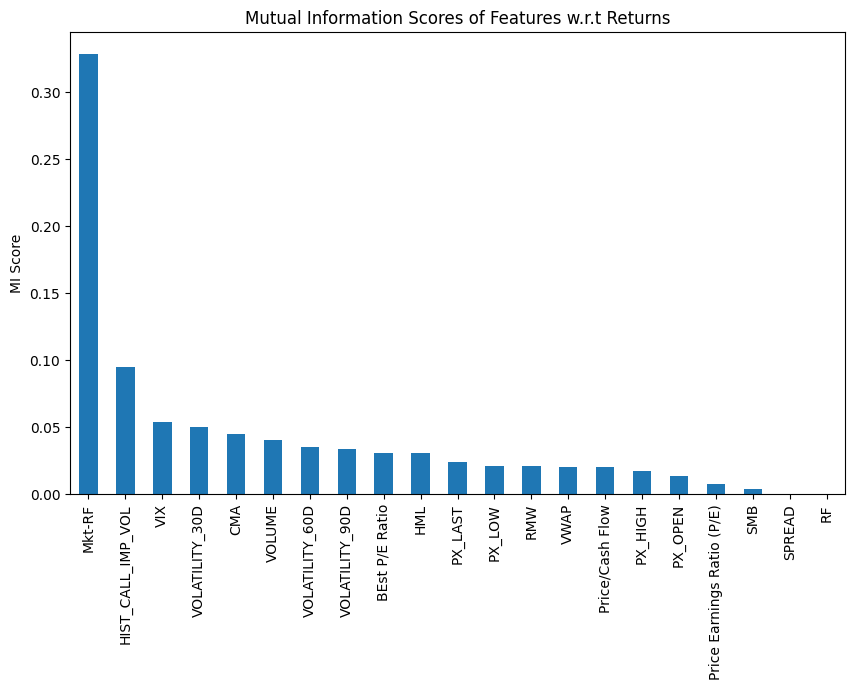

In [48]:
mi_scores = mutual_info_regression(X_train, y_train)

# Create a pandas Series for better visualization
mi_series = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)

# Sort the scores for better interpretability
mi_series = mi_series.sort_values(ascending=False)

# Print the mutual information scores
print("Mutual Information Scores:")
print(mi_series)

# Optional: Plot the mutual information scores
plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar')
plt.title('Mutual Information Scores of Features w.r.t Returns')
plt.ylabel('MI Score')
plt.show()

In [49]:
# List of features to remove
features_to_drop = ['SPREAD', 'RF']

# Drop them from all feature sets
X_train = X_train.drop(columns=features_to_drop)
X_val = X_val.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [50]:
# Verify that the specified columns have been successfully removed
print("Shape:", X_train.shape)

Shape: (2641, 19)


## Data Partitioning: Train, Validation, Test

Prior to splitting the data, we remove the irrelevant features previously identified.

In [51]:
df_cleaned = df.drop(columns=['Date', 'PX_ASK', 'PX_BID','SPREAD','RF'])
# data = df_clean.values

In [52]:
print("---------------------------------------")
print("Shape:", df_cleaned.shape) # here, the dataset should contain one additional variable, as the returns have not yet been removed
print("---------------------------------------")

---------------------------------------
Shape: (3774, 20)
---------------------------------------


In [58]:
# Define X and y
X = df_cleaned.drop(columns=['Returns'])  # Features colums: All columns except 'Returns'
y = df_cleaned['Returns']                 # Target column

# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=2)

# Step 2: Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=2)

In [59]:
# Check shapes of the datasets
print("X_train shape:", X_train.shape)  # Expected: (num_train_samples, 60, 3)
print("y_train shape:", y_train.shape)  # Expected: (num_train_samples,)

print("X_val shape:", X_val.shape)      # Expected: (num_val_samples, 60, 3)
print("y_val shape:", y_val.shape)      # Expected: (num_val_samples,)

print("X_test shape:", X_test.shape)    # Expected: (num_test_samples, 60, 3)
print("y_test shape:", y_test.shape)    # Expected: (num_test_samples,)

X_train shape: (2641, 19)
y_train shape: (2641,)
X_val shape: (566, 19)
y_val shape: (566,)
X_test shape: (567, 19)
y_test shape: (567,)


-----
# BASELINE FIT XGBOOST REGRESSION MODEL - in-sample
Cross-validation is used to evaluate a model's performance by splitting the training data into multiple folds. The model is trained on some folds and validated on the remaining ones, helping estimate how well it generalizes to unseen data — without relying on the test set.

In [60]:
# XGBoost parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

# Definition of a baseline xgb:
xgb_baseline = XGBRegressor(booster='gbtree',         # base learner "gradient boosted tree".  It's uncommon but possible to work with other base learners.
                    objective='reg:squarederror',     # This tells XGBoost what kind of loss function to use
                    # max_depth=6                     # Number of branches each tree has. XGBoost uses a default of 6.
                    # learning_rate=0.1,              # This hyperparameter limits the variance by reducing the weight of each tree to the given percentage.
                    # n_estimators=100,               #  n_estimators is the number of boosted trees in the model. Increasing this number while decreasing learning_rate can lead to more robust results.
                    random_state=2,
                    n_jobs=-1)                        # Use all available CPU cores in parallel when training the model.

# The goal is to compare this value with the performance of the optimized XGBoost model

In [61]:
# define the number of split of cross-validation
split=10

# Compute RMSE using 5-fold cross-validation
neg_mse_scores  = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=split)
rmse = np.sqrt(-neg_mse_scores) # Take square root of the scores - regression are commonly displayed as the Root Mean Squared Error (RMSE) to keep the units the same.

# Compute R² using 5-fold cross-validation
r2_scores = cross_val_score(xgb_baseline, X_train, y_train, scoring='r2', cv=split)

# Display results
print('R² (per fold):', np.round(r2_scores, 4))
print('Mean R²: {:.5f}'.format(r2_scores.mean()))

print('RMSE (per fold):', np.round(rmse, 4))
print('Mean RMSE: {:.5f}'.format(rmse.mean()))

R² (per fold): [0.4674 0.5192 0.3367 0.3814 0.5977 0.3203 0.454  0.5057 0.4117 0.5936]
Mean R²: 0.45875
RMSE (per fold): [0.0138 0.013  0.0127 0.013  0.0115 0.0119 0.0137 0.0137 0.0127 0.0119]
Mean RMSE: 0.01278


In [62]:
pd.DataFrame(y).describe()

,Returns
count,3774.000000
mean,0.001079
std,0.017558
min,-0.128646
25%,-0.007481
50%,0.000970
75%,0.010338
max,0.119807


### Model Evaluation Using K-Fold Cross-Validation

We apply also K-Fold cross-validation to evaluate model performance more reliably.
This approach reduces variance in the error estimate by averaging results across folds.
RMSE is used as the evaluation metric to reflect the prediction error in original units.


In [63]:
# computing the RMSE using KFOLD inside cross validation (Kfold can be used  inside cross_val_score, GridSeachCV, and RandomizedSearchCV to ensure consistent results )
kfold = KFold(n_splits=10, shuffle=True, random_state=2)

# I cahanged the scores using Kfold for -MSE
neg_mse_scores_Kfold = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)
rmse_Kfold = np.sqrt(-neg_mse_scores_Kfold) # Take square root of the scores - regression are commonly displayed as the Root Mean Squared Error (RMSE) to keep the units the same.

# I cahanged the scores using Kfold for R²
r2_scores_Kfold = cross_val_score(xgb_baseline, X_train, y_train, scoring='r2', cv=kfold)

# Display results
print('R² (per fold):', np.round(r2_scores_Kfold, 4))
print('Mean R²: {:.5f}'.format(r2_scores_Kfold.mean()))

print('RMSE (per fold):', np.round(rmse_Kfold, 4))
print('Mean RMSE: {:.5f}'.format(rmse_Kfold.mean()))

print("-----------------------------------------------------------------------------------------------------------------------------------")
print(f'We will use the RMSE mean of {rmse_Kfold.mean():.5f} and the R² mean of {r2_scores_Kfold.mean():.5f} as a baseline to evaluate whether hyperparameter tuning improves model performance.')


R² (per fold): [0.5324 0.3744 0.6217 0.4263 0.5119 0.4889 0.5004 0.4697 0.4197 0.4697]
Mean R²: 0.48151
RMSE (per fold): [0.0125 0.0138 0.0109 0.0127 0.0131 0.0124 0.0128 0.0113 0.0134 0.0135]
Mean RMSE: 0.01263
-----------------------------------------------------------------------------------------------------------------------------------
We will use the RMSE mean of 0.01263 and the R² mean of 0.48151 as a baseline to evaluate whether hyperparameter tuning improves model performance.


-----
# EXPLORING ALTERNATIVE BASE LEARNERS IN XGBOOST

In this section, we evaluate different boosters and Random Forest variants within the XGBoost framework (`gbtree`, `gblinear`, `dart`, and `XGBRF`).  
The models are assessed using **cross-validation** with 10 folds, both through the standard `cross_val_score` interface and by explicitly applying a **K-Fold strategy**.  
The evaluation metrics reported are the coefficient of determination ($R^2$) and the Root Mean Squared Error (RMSE), computed for each fold and on average.

In [64]:
models = {
    # gbtree
    'gbtree': XGBRegressor(booster='gbtree', objective='reg:squarederror', random_state=2, n_jobs=-1),

    # Random Forest - 1st method
    'Random Forest 1': XGBRegressor(booster='gbtree', objective='reg:squarederror', num_parallel_tree=5, random_state=2, n_jobs=-1), # we use 'um_parallel_tree=5' to add tree.
    # Boosting is intended to combine many weak learners, not strong ones.
    # Therefore, keep num_parallel_tree close to 1 when using boosting methods.

    # Random Forest - 2nd method
    'Random Forest 2': XGBRFRegressor(objective='reg:squarederror', random_state=2, n_jobs=-1), # we have used XGBRF
    # In XGBRFRegressor, it is recommended to keep learning_rate = 1,
    # as it does not perform boosting but builds trees independently.

    # Random Forest - 3rd method
    'Random Forest 3': RandomForestRegressor(random_state=2, n_jobs=-1), # we have used XGBRF

    # gblinear
    'gblinear': XGBRegressor(booster='gblinear', objective='reg:squarederror', random_state=2, n_jobs=-1),

    # Dart
    'dart': XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1),

    # Dart UNIFORM - trees are dropped with equal probability, regardless of their individual importance.
    'dart Uniform': XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1),

    # Dart WEIGHTED - trees are dropped proportionally to their weights — more important trees have a higher chance of being dropped.
    'dart Weighted': XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1),

    # Dart TREE -  new tree weight = weight of each dropped tree.
    'dart Tree': XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1),

    # Dart FOREST - new tree weight = total weight of all dropped trees.
    'dart Forest': XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1),

    # Dart ONE DROP - one_drop ensures that at least one tree is always dropped during the boosting round.
    'dart One Drop': XGBRegressor(booster='dart', objective='reg:squarederror', one_drop=1, random_state=2, n_jobs=-1),

}

In [65]:
# CROSS-VALIDATION

# Number of folds
split = 10

# Evaluate each model
for name, model in models.items():
    print(f"\n🔍 Results for booster: {name}")

    # RMSE
    neg_mse_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=split)
    rmse = np.sqrt(-neg_mse_scores)

    # R²
    r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=split)

    # Display results
    print('R² (per fold):', np.round(r2_scores, 4))
    print('Mean R²: {:.5f}'.format(r2_scores.mean()))
    print('RMSE (per fold):', np.round(rmse, 4))
    print('Mean RMSE: {:.5f}'.format(rmse.mean()))


🔍 Results for booster: gbtree
R² (per fold): [0.4674 0.5192 0.3367 0.3814 0.5977 0.3203 0.454  0.5057 0.4117 0.5936]
Mean R²: 0.45875
RMSE (per fold): [0.0138 0.013  0.0127 0.013  0.0115 0.0119 0.0137 0.0137 0.0127 0.0119]
Mean RMSE: 0.01278

🔍 Results for booster: Random Forest 1
R² (per fold): [0.4674 0.5192 0.3367 0.3814 0.5977 0.3203 0.454  0.5057 0.4117 0.5936]
Mean R²: 0.45875
RMSE (per fold): [0.0138 0.013  0.0127 0.013  0.0115 0.0119 0.0137 0.0137 0.0127 0.0119]
Mean RMSE: 0.01278

🔍 Results for booster: Random Forest 2
R² (per fold): [0.4825 0.519  0.3678 0.4363 0.5395 0.2078 0.4693 0.5256 0.4571 0.6205]
Mean R²: 0.46253
RMSE (per fold): [0.0136 0.013  0.0124 0.0124 0.0123 0.0129 0.0135 0.0134 0.0122 0.0115]
Mean RMSE: 0.01271

🔍 Results for booster: Random Forest 3
R² (per fold): [0.5043 0.5567 0.3904 0.4774 0.5771 0.2866 0.4857 0.5449 0.4759 0.6886]
Mean R²: 0.49875
RMSE (per fold): [0.0133 0.0125 0.0122 0.0119 0.0118 0.0122 0.0133 0.0132 0.012  0.0104]
Mean RMSE: 0.01227



In [66]:
# KFOLD

# Define KFold cross-validation strategy
kfold = KFold(n_splits=10, shuffle=True, random_state=2)

# Evaluate each model using KFold
for name, model in models.items():
    print(f"\n🔍 Results for booster: {name} (using KFold CV)")

    # RMSE
    neg_mse_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)
    rmse = np.sqrt(-neg_mse_scores)

    # R²
    r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kfold)

    # Display results
    print('R² (per fold):', np.round(r2_scores, 4))
    print('Mean R²: {:.5f}'.format(r2_scores.mean()))
    print('RMSE (per fold):', np.round(rmse, 4))
    print('Mean RMSE: {:.5f}'.format(rmse.mean()))


🔍 Results for booster: gbtree (using KFold CV)
R² (per fold): [0.5324 0.3744 0.6217 0.4263 0.5119 0.4889 0.5004 0.4697 0.4197 0.4697]
Mean R²: 0.48151
RMSE (per fold): [0.0125 0.0138 0.0109 0.0127 0.0131 0.0124 0.0128 0.0113 0.0134 0.0135]
Mean RMSE: 0.01263

🔍 Results for booster: Random Forest 1 (using KFold CV)
R² (per fold): [0.5324 0.3744 0.6217 0.4263 0.5119 0.4889 0.5004 0.4697 0.4197 0.4697]
Mean R²: 0.48151
RMSE (per fold): [0.0125 0.0138 0.0109 0.0127 0.0131 0.0124 0.0128 0.0113 0.0134 0.0135]
Mean RMSE: 0.01263

🔍 Results for booster: Random Forest 2 (using KFold CV)
R² (per fold): [0.5428 0.3246 0.5831 0.5222 0.5276 0.4856 0.4632 0.4434 0.4523 0.4821]
Mean R²: 0.48269
RMSE (per fold): [0.0123 0.0143 0.0114 0.0116 0.0129 0.0124 0.0132 0.0115 0.013  0.0133]
Mean RMSE: 0.01262

🔍 Results for booster: Random Forest 3 (using KFold CV)
R² (per fold): [0.5524 0.3735 0.5918 0.5564 0.5628 0.525  0.5354 0.4745 0.4315 0.5036]
Mean R²: 0.51068
RMSE (per fold): [0.0122 0.0138 0.0113 0.

*comment:* Since the *gblinear* booster achieved the best performance in terms of both **\(R^2\)** and **RMSE** across the cross-validation folds, we proceed with this model for further analysis.


-----
# TUNING XGBoost HYPERPARAMETERS


Now that we’ve established a baseline model and evaluated its performance, the next step is to tune the hyperparameters of our XGBoost model individually.
The objective is to systematically explore the effect of each key hyperparameter—such as max_depth, learning_rate, n_estimators, and subsample—on model performance.

We’ll begin by varying one hyperparameter at a time while keeping the others fixed, allowing us to isolate its effect. After gaining insight into each parameter's impact, we can later combine the most promising values in a full grid or randomized search for fine-tuning.

### Combining GridSearchCV and RandomizedSearchCV
GridSearchCV searches all possible combinations in a hyperparameter grid to find the best results. RandomizedSearchCV selects
 10 random hyperparameter combinations by default. RandomizedSearchCV is typically used when GridSearchCV becomes
 unwieldy because there are too many hyperparameter combinations to exhaustively check each one.

In [67]:
# I selected between Grid Search (comprehensive but slow) and Random Search (faster but less precise).

def grid_search(params, model=None, random=False):        # GridSearchCV searches all possible combinations in a hyperparameter grid to find the best results.
                                              # Change in 'random=True' if you want to use RandomizedSearchCV (in case of slow computation).
    if model is None:
        model = XGBRegressor(booster='gblinear',                # sets up a basic XGBoost regression model.
                                objective='reg:squarederror',
                                random_state=2,
                                n_jobs=-1)

    # The next part is used to find hyperparameters:
    kfold = KFold(n_splits=10, shuffle=True, random_state=2) # same of before

    if random:                                      # Randomly samples from the parameter grid instead of checking all combinations. RandomizedSearchCV selects 10 random hyperparameter combinations by default.
        grid = RandomizedSearchCV(xgb_baseline,     # RandomizedSearchCV is typically used when GridSearchCV becomes unwieldy because there are too many hyperparameter combinations to exhaustively check each one
                                  params,
                                  cv=kfold,         # Use k-fold cross-validation to validate each configuration.
                                  n_iter=20,        # Try 20 random combinations.
                                  n_jobs=-1,
                                  random_state=2,
                                  scoring={'r2': 'r2', 'neg_mse': 'neg_mean_squared_error'}, # By default scoring is R² for regressors. In case you prefer you need sto specify it.
                                  refit='r2')

    else:                                      # If 'random=False'. Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb_baseline,      # GridSearchCV checks every possible combination in the parameter grid exhaustively.
                            params,
                            cv=kfold,
                            n_jobs=-1,
                            scoring={'r2': 'r2', 'neg_mse': 'neg_mean_squared_error'},
                            refit='r2')

    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best parameters
    best_params = grid.best_params_
    print("Best params:", best_params)

    # Compute best score (R²)
    best_score = grid.best_score_       # Using grid.best_score_ returns the best model's average score across all cross-validation folds — it does not provide the individual fold scores as seen in earlier per-fold evaluations.
    print("Best score (R²): {:.5f}".format(best_score))

    # Compute best score (RMSE)
    mean_neg_mse = grid.cv_results_['mean_test_neg_mse'][grid.best_index_] # Scikit-learn are built to maximize a score during model selection. But MSE is a loss function that we want to minimize. So instead, scikit-learn uses the negative of MSE.
    rmse = (-mean_neg_mse) ** 0.5
    print("Best score (RMSE): {:.5f}".format(rmse))

    print('====================================================================')

    # Predict on the validation or test set using best model
    y_pred = grid.predict(X_val)  # or X_test if you prefer

    # Calculate R²
    r2 = r2_score(y_val, y_pred)
    print("R² score on validation set: {:.5f}".format(r2))

    # Calculate RMSE
    rmse = mean_squared_error(y_val, y_pred)**0.5 # Calculate RMSE directly
    print("RMSE on validation set: {:.5f}".format(rmse))

    # Calculate MAE
    mae = mean_absolute_error(y_val, y_pred)
    print("MAE on validation set: {:.5f}".format(mae))

    # Calculate MAD (same as MAE but explicitly named)
    mad = abs(y_val - y_pred).mean()
    print("MAD on validation set: {:.5f}".format(mad))

    # --- Directional Accuracy ---
    def directional_accuracy(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate the direction of actual and predicted change
        actual_direction = np.sign(y_true[1:] - y_true[:-1])
        predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])

        # Compute directional accuracy
        return np.mean(actual_direction == predicted_direction)

    da = directional_accuracy(y_val, y_pred)
    print("Directional Accuracy on validation set: {:.5f}".format(da))



If you choose to use RandomizedSearchCV, you can enable it by setting 'random=True'.

## Tuning XGBoost Hyperparameters - INDIVIDUALLY
In this section, the hyperparameters of XGBoost are tuned individually to assess their impact on model performance.

In [68]:
# n_estimators provides the number of trees.
grid_search(params={'n_estimators':[0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 20, 21, 25, 30, 50, 75, 100]}, random=False)

Best params: {'n_estimators': 21}
Best score (R²): 0.49015
Best score (RMSE): 0.01257
R² score on validation set: 0.46862
RMSE on validation set: 0.01283
MAE on validation set: 0.00899
MAD on validation set: 0.00899
Directional Accuracy on validation set: 0.70265


In [69]:
# learning_rate shrinks the weights of trees for each round of boosting. Lowering learning_rate prevents overfitting.
grid_search(params={'learning_rate':[0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]}, random=False)

Best params: {'learning_rate': 0.06}
Best score (R²): 0.50756
Best score (RMSE): 0.01235
R² score on validation set: 0.47537
RMSE on validation set: 0.01275
MAE on validation set: 0.00895
MAD on validation set: 0.00895
Directional Accuracy on validation set: 0.73274


In [70]:
# Max_depth determines the length of the tree.
grid_search(params={'max_depth':[0, 1, 2, 3, 5, 6, 8]}, random=False)

Best params: {'max_depth': 2}
Best score (R²): 0.52034
Best score (RMSE): 0.01219
R² score on validation set: 0.47748
RMSE on validation set: 0.01272
MAE on validation set: 0.00902
MAD on validation set: 0.00902
Directional Accuracy on validation set: 0.72743


In [71]:
# Gamma is Known as a Lagrange multiplier, gamma provides a threshold that nodes must surpass before making further splits according to the loss function.
grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]}, random=False)

Best params: {'gamma': 0}
Best score (R²): 0.48151
Best score (RMSE): 0.01266
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [72]:
# min_child_weight refers to the minimum sum of weights required for a node to split into a child.
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15]}, random=False)

Best params: {'min_child_weight': 11}
Best score (R²): 0.48700
Best score (RMSE): 0.01261
R² score on validation set: 0.46219
RMSE on validation set: 0.01291
MAE on validation set: 0.00912
MAD on validation set: 0.00912
Directional Accuracy on validation set: 0.72920


In [73]:
# The subsample hyperparameter limits the percentage of training instances (rows) for each boosting round. A decrease reduce overfitting.
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'subsample': 0.9}
Best score (R²): 0.48262
Best score (RMSE): 0.01265
R² score on validation set: 0.49659
RMSE on validation set: 0.01249
MAE on validation set: 0.00899
MAD on validation set: 0.00899
Directional Accuracy on validation set: 0.72389


In [74]:
# Similar to subsample, colsample_bytree randomly selects particular columns according to the given percentage. Colsample_bytree is useful for limiting the influence of columns and reducing variance.
grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]}, random=False)
# note: percentage

Best params: {'colsample_bytree': 0.7}
Best score (R²): 0.49185
Best score (RMSE): 0.01254
R² score on validation set: 0.44669
RMSE on validation set: 0.01309
MAE on validation set: 0.00923
MAD on validation set: 0.00923
Directional Accuracy on validation set: 0.71327


## Tuning XGBoost Hyperparameters - COMBINED
In this section, multiple hyperparameters of XGBoost are tuned jointly to optimize model performance.

In [75]:
grid_search(params={'n_estimators':[0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 20, 21, 25, 30, 50, 75, 100]})

Best params: {'n_estimators': 21}
Best score (R²): 0.49015
Best score (RMSE): 0.01257
R² score on validation set: 0.46862
RMSE on validation set: 0.01283
MAE on validation set: 0.00899
MAD on validation set: 0.00899
Directional Accuracy on validation set: 0.70265


In [76]:
grid_search(params={'max_depth':[1, 2, 3, 4, 6, 7, 8],
                    'n_estimators':[21]})

Best params: {'max_depth': 4, 'n_estimators': 21}
Best score (R²): 0.50402
Best score (RMSE): 0.01239
R² score on validation set: 0.44570
RMSE on validation set: 0.01310
MAE on validation set: 0.00920
MAD on validation set: 0.00920
Directional Accuracy on validation set: 0.72920


In [77]:
# A limitation with the approach of keeping the top values is that we may miss out on better combinations.
# Perhaps n_estimators=2 or n_esimtators=100 gives better results in conjunction with max_depth.
grid_search(params={'max_depth':[1, 2, 3, 4, 6, 7, 8],
                    'n_estimators':[10, 12, 13, 14, 15, 20, 21, 23, 25, 30, 35, 50, 75, 100, 125, 150, 200]}, random=False)

Best params: {'max_depth': 2, 'n_estimators': 100}
Best score (R²): 0.52034
Best score (RMSE): 0.01219
R² score on validation set: 0.47748
RMSE on validation set: 0.01272
MAE on validation set: 0.00902
MAD on validation set: 0.00902
Directional Accuracy on validation set: 0.72743


In [78]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5],
                    'max_depth':[2],
                    'n_estimators':[100]})

Best params: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
Best score (R²): 0.52034
Best score (RMSE): 0.01219
R² score on validation set: 0.47748
RMSE on validation set: 0.01272
MAE on validation set: 0.00902
MAD on validation set: 0.00902
Directional Accuracy on validation set: 0.72743


In [79]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5],
                    'max_depth':[2],
                    'n_estimators':[100]})

Best params: {'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
Best score (R²): 0.52034
Best score (RMSE): 0.01219
R² score on validation set: 0.47748
RMSE on validation set: 0.01272
MAE on validation set: 0.00902
MAD on validation set: 0.00902
Directional Accuracy on validation set: 0.72743


In [80]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'max_depth':[2],
                    'n_estimators':[100]})

Best params: {'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
Best score (R²): 0.52321
Best score (RMSE): 0.01216
R² score on validation set: 0.45361
RMSE on validation set: 0.01301
MAE on validation set: 0.00900
MAD on validation set: 0.00900
Directional Accuracy on validation set: 0.71858


In [81]:
# Recall that RandomizedSearchCV is useful when the total number of combinations is too time-consuming for a grid search.

grid_search(params={'subsample':[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'min_child_weight':[1, 2, 3, 4, 5],
                    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
                    'max_depth':[1, 2, 3, 4, 5, 6, 7, None],
                    'n_estimators':[2, 10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]}, random=True)

Best params: {'subsample': 0.5, 'n_estimators': 75, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.2}
Best score (R²): 0.51125
Best score (RMSE): 0.01230
R² score on validation set: 0.46683
RMSE on validation set: 0.01285
MAE on validation set: 0.00897
MAD on validation set: 0.00897
Directional Accuracy on validation set: 0.71504


Secondary tuning knobs, more useful for fine-tuning or reducing overfitting:
- colsample by tree
- colsample by level
- colsample by node
- gamma

In [82]:
grid_search(params={'subsample':[0.5],
                    'min_child_weight':[2],
                    'learning_rate':[0.2],
                    'max_depth':[5],
                    'n_estimators':[75],
                    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1]}, random=True,)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'subsample': 0.5, 'n_estimators': 75, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Best score (R²): 0.51204
Best score (RMSE): 0.01227
R² score on validation set: 0.43664
RMSE on validation set: 0.01321
MAE on validation set: 0.00926
MAD on validation set: 0.00926
Directional Accuracy on validation set: 0.73982


In [83]:
grid_search(params={'subsample':[0.5],
                    'min_child_weight':[2],
                    'learning_rate':[0.2],
                    'max_depth':[5],
                    'n_estimators':[75],
                    'colsample_bytree':[0.7],
                    'colsample_bylevel':[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, random=True,)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=20. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'subsample': 0.5, 'n_estimators': 75, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 1}
Best score (R²): 0.51204
Best score (RMSE): 0.01227
R² score on validation set: 0.43664
RMSE on validation set: 0.01321
MAE on validation set: 0.00926
MAD on validation set: 0.00926
Directional Accuracy on validation set: 0.73982


In [84]:
grid_search(params={'subsample':[0.5],
                    'min_child_weight':[2],
                    'learning_rate':[0.2],
                    'max_depth':[5],
                    'n_estimators':[75],
                    'colsample_bytree':[0.7],
                    'colsample_bylevel':[1],
                    'colsample_bynode':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    }, random=True,)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'subsample': 0.5, 'n_estimators': 75, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'colsample_bynode': 1, 'colsample_bylevel': 1}
Best score (R²): 0.51204
Best score (RMSE): 0.01227
R² score on validation set: 0.43664
RMSE on validation set: 0.01321
MAE on validation set: 0.00926
MAD on validation set: 0.00926
Directional Accuracy on validation set: 0.73982


In [85]:
grid_search(params={'subsample':[0.5],
                    'min_child_weight':[2],
                    'learning_rate':[0.2],
                    'max_depth':[5],
                    'n_estimators':[75],
                    'colsample_bytree':[0.7],
                    'colsample_bylevel':[1],
                    'colsample_bynode':[1],
                    'gamma':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3],
                    }, random=True,)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'subsample': 0.5, 'n_estimators': 75, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7, 'colsample_bynode': 1, 'colsample_bylevel': 1}
Best score (R²): 0.51204
Best score (RMSE): 0.01227
R² score on validation set: 0.43664
RMSE on validation set: 0.01321
MAE on validation set: 0.00926
MAD on validation set: 0.00926
Directional Accuracy on validation set: 0.73982


## Tuning XGBoost Hyperparameters - WITH DART BOOSTER: HYPERPARAMETER SEARCH
In this section, specific hyperparameters of the DART booster, such as rate_drop and skip_drop, are tuned to investigate their effect on model performance.

In [86]:
# Rate Drop test with DART booster
grid_search(
    params={'rate_drop': [0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
    model=XGBRegressor(booster='dart', objective='reg:squarederror', one_drop=1, random_state=2, n_jobs=-1)
)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:41:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "rate_drop" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'rate_drop': 0.01}
Best score (R²): 0.48151
Best score (RMSE): 0.01266
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [87]:
# Skip Drop test with DART booster
grid_search(
    params={'skip_drop': [0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
    model=XGBRegressor(booster='dart', objective='reg:squarederror', one_drop=1, random_state=2, n_jobs=-1)
)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:42:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "skip_drop" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'skip_drop': 0.01}
Best score (R²): 0.48151
Best score (RMSE): 0.01266
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


The hyperparameter search for `rate_drop` and `skip_drop` in the DART booster did not yield any meaningful improvement in predictive performance. Since the validation metrics remained largely unchanged, I decided to skip further tuning of these parameters on the out-of-sample data and instead focus on other hyperparameters with a stronger impact on model accuracy.



-----
# IMPROVING PREDICTION ACCURACY WITH VOTING REGRESSOR and STACKING REGRESSOR - ON VALIDATION DATA


## Voting Regressor model
We apply a Voting Regressor to combine multiple models (XGB, RF, LR) into a single ensemble. In this approach, the base models generate predictions on the original data, and the final output is obtained by averaging these predictions (optionally using weights).

In [ ]:
# model has been defined before:

# model = XGBRegressor(booster='gblinear',
#                      objective='reg:squarederror',
#                      random_state=2,
#                       n_jobs=-1)

In [97]:
def y_pred(model):
    model.fit(X_train, y_train)

    # Predict on the validation or test set using best model
    y_pred = model.predict(X_val)

    print(" --- Scores on validation set ---")

    # Calculate R²
    r2 = r2_score(y_val, y_pred)
    print("R² score on validation set: {:.5f}".format(r2))

    # Calculate RMSE
    rmse = mean_squared_error(y_val, y_pred)**0.5 # Calculate RMSE directly
    print("RMSE on validation set: {:.5f}".format(rmse))

    # Calculate MSE
    mse = mean_squared_error(y_val, y_pred)
    print("MSE on validation set: {:.5f}".format(mse))

    # Calculate MAE
    mae = mean_absolute_error(y_val, y_pred)
    print("MAE on validation set: {:.5f}".format(mae))

    # Calculate MAD (same as MAE but explicitly named)
    mad = abs(y_val - y_pred).mean()
    print("MAD on validation set: {:.5f}".format(mad))

    # --- Directional Accuracy ---
    def directional_accuracy(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate the direction of actual and predicted change
        actual_direction = np.sign(y_true[1:] - y_true[:-1])
        predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])

        # Compute directional accuracy
        return np.mean(actual_direction == predicted_direction)

    da = directional_accuracy(y_val, y_pred)
    print("Directional Accuracy on validation set: {:.5f}".format(da))

    return y_pred

We began by running various learning models on validation set and evaluating their performance.

In [98]:
y_pred_gbtree = y_pred(XGBRegressor(booster='gbtree', objective='reg:squarederror', random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MSE on validation set: 0.00016
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [99]:
# Random Forest 1: XGBRegressor (gbtree) + num_parallel_tree=5 — boosted trees; 5 trees per boosting round.
y_pred_RF_1 = y_pred(XGBRegressor(booster='gbtree', objective='reg:squarederror', num_parallel_tree=5, random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MSE on validation set: 0.00016
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [100]:
# Random Forest 2: XGBRFRegressor — XGBoost’s true Random Forest (bagging + column subsampling; no boosting).
y_pred_RF_2= y_pred(XGBRFRegressor(objective='reg:squarederror', random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.41623
RMSE on validation set: 0.01345
MSE on validation set: 0.00018
MAE on validation set: 0.00934
MAD on validation set: 0.00934
Directional Accuracy on validation set: 0.71681


In [101]:
# Random Forest 3: sklearn RandomForestRegressor — classic Breiman RF (bootstrap + feature subsampling).
y_pred_RF_3= y_pred(RandomForestRegressor(random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.46265
RMSE on validation set: 0.01290
MSE on validation set: 0.00017
MAE on validation set: 0.00903
MAD on validation set: 0.00903
Directional Accuracy on validation set: 0.70973


In [102]:
y_pred_gblinear= y_pred(XGBRegressor(booster='gblinear', objective='reg:squarederror', random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.45573
RMSE on validation set: 0.01298
MSE on validation set: 0.00017
MAE on validation set: 0.00887
MAD on validation set: 0.00887
Directional Accuracy on validation set: 0.74513


In [103]:
y_pred_dart= y_pred(XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MSE on validation set: 0.00016
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [104]:
y_pred_dart_uniform= y_pred(XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MSE on validation set: 0.00016
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [105]:
y_pred_dart_weighted= y_pred(XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MSE on validation set: 0.00016
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [106]:
y_pred_dart_tree= y_pred(XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MSE on validation set: 0.00016
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [107]:
y_pred_dart_forest= y_pred(XGBRegressor(booster='dart', objective='reg:squarederror', random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.47099
RMSE on validation set: 0.01280
MSE on validation set: 0.00016
MAE on validation set: 0.00906
MAD on validation set: 0.00906
Directional Accuracy on validation set: 0.70265


In [108]:
y_pred_dart_one_drop= y_pred(XGBRegressor(booster='dart', objective='reg:squarederror', one_drop=1, random_state=2, n_jobs=-1))

 --- Scores on validation set ---
R² score on validation set: 0.48898
RMSE on validation set: 0.01258
MSE on validation set: 0.00016
MAE on validation set: 0.00893
MAD on validation set: 0.00893
Directional Accuracy on validation set: 0.72389


Model Prediction Correlation Analysis

In [109]:
df_pred = pd.DataFrame(data= np.c_[y_pred_gbtree,
                                   y_pred_RF_1,
                                   y_pred_RF_2,
                                   y_pred_RF_3,
                                   y_pred_gblinear,
                                   y_pred_dart,
                                   y_pred_dart_uniform,
                                   y_pred_dart_weighted,
                                   y_pred_dart_tree,
                                   y_pred_dart_forest,
                                   y_pred_dart_one_drop],

                  columns=['gbtree', 'RF1','RF2', 'RF3', 'linear', 'dart', 'd_unif', 'd_weight', 'd_tree', 'd_forest', 'd_onedrop'])

df_pred.corr()

,gbtree,RF1,RF2,RF3,linear,dart,d_unif,d_weight,d_tree,d_forest,d_onedrop
gbtree,1.000000,1.000000,0.871702,0.895622,0.857781,1.000000,1.000000,1.000000,1.000000,1.000000,0.933584
RF1,1.000000,1.000000,0.871702,0.895622,0.857781,1.000000,1.000000,1.000000,1.000000,1.000000,0.933584
RF2,0.871702,0.871702,1.000000,0.962041,0.932826,0.871702,0.871702,0.871702,0.871702,0.871702,0.908502
RF3,0.895622,0.895622,0.962041,1.000000,0.935002,0.895622,0.895622,0.895622,0.895622,0.895622,0.933595
linear,0.857781,0.857781,0.932826,0.935002,1.000000,0.857781,0.857781,0.857781,0.857781,0.857781,0.880775
dart,1.000000,1.000000,0.871702,0.895622,0.857781,1.000000,1.000000,1.000000,1.000000,1.000000,0.933584
d_unif,1.000000,1.000000,0.871702,0.895622,0.857781,1.000000,1.000000,1.000000,1.000000,1.000000,0.933584
d_weight,1.000000,1.000000,0.871702,0.895622,0.857781,1.000000,1.000000,1.000000,1.000000,1.000000,0.933584
d_tree,1.000000,1.000000,0.871702,0.895622,0.857781,1.000000,1.000000,1.000000,1.000000,1.000000,0.933584
d_forest,1.000000,1.000000,0.871702,0.895622,0.857781,1.000000,1.000000,1.000000,1.000000,1.000000,0.933584


In [110]:
# Unstack the correlation matrix and sort the values
stacked_corr = df_pred.corr().unstack()

# Remove self-correlations and duplicate pairs
sorted_corr = stacked_corr[stacked_corr != 1]
sorted_corr = sorted_corr.drop_duplicates()

# Get the top N least correlated pairs (use ascending=True)
top_uncorrelated = sorted_corr.sort_values(ascending=True).head(10)

print("Top 15 Least Correlated Model Pairs:")
display(top_uncorrelated)

Top 15 Least Correlated Model Pairs:


,,0
RF1,linear,0.857781
linear,dart,0.857781
gbtree,linear,0.857781
RF1,RF2,0.871702
RF2,dart,0.871702
gbtree,RF2,0.871702
linear,d_onedrop,0.880775
RF1,RF3,0.895622
RF3,dart,0.895622
gbtree,RF3,0.895622


Fitting the Voting Regressor Model

We now sort the least correlated model predictions, since lower correlation indicates greater diversity in errors. This is desirable in ensemble methods like `VotingRegressor`, which perform best when individual models are accurate but make different, uncorrelated mistakes.

To this end, several combinations of the models listed above were tested in order to identify the most effective ensemble configuration.

In [111]:
# Define models
estimators = []

# Random Forest 1
RF1_model = XGBRegressor(booster='gbtree', objective='reg:squarederror', num_parallel_tree=5, random_state=2, n_jobs=-1)
estimators.append(('RF1', RF1_model))

# Linear model
gblinear_model = XGBRegressor(booster='gblinear', objective='reg:squarederror', random_state=2, n_jobs=-1)
estimators.append(('gblinear', gblinear_model)) # Changed name to 'gblinear'

# gbtree model
gbtree_model = XGBRegressor(booster='gbtree', random_state=2)
estimators.append(('gbtree', gbtree_model))

# VOTING REGRESSOR ENSEMBLE - THIS IS THE ENSEMBLE MODEL
ensemble = VotingRegressor(estimators)

# R² score (default)
r2_scores = cross_val_score(ensemble, X_train, y_train, cv=kfold, scoring='r2')
print(f"R² Score: {r2_scores.mean():.4f}")

# MSE (negated, so we take the negative to make it positive)
mse_scores = cross_val_score(ensemble, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print(f"Mean Squared Error: {-mse_scores.mean():.4f}")

R² Score: 0.5369
Mean Squared Error: 0.0001


Evaluation of Voting Regressor on Validation Set

In [112]:
# --- Fit ensemble on training set ---
ensemble.fit(X_train, y_train)

# --- Predict on validation set ---
y_val_pred = ensemble.predict(X_val)

# --- Evaluation on validation set ---
# R²
r2_val = r2_score(y_val, y_val_pred)
print(f"R² Score (Validation): {r2_val:.4f}")

# RMSE
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE (Validation): {rmse_val:.4f}")

# MSE
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"MSE (Validation): {mse_val:.4f}")

# MAE
mae_val = mean_absolute_error(y_val, y_val_pred)
print(f"MAE (Validation): {mae_val:.4f}")

# MAD (same as MAE, printed explicitly)
mad_val = np.mean(np.abs(y_val - y_val_pred))
print(f"MAD (Validation): {mad_val:.4f}")

# --- Directional Accuracy ---
def directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    actual_dir    = np.sign(y_true[1:] - y_true[:-1])
    predicted_dir = np.sign(y_pred[1:] - y_pred[:-1])
    return np.mean(actual_dir == predicted_dir)

da_val = directional_accuracy(y_val, y_val_pred)
print(f"Directional Accuracy (Validation): {da_val:.4f}")


R² Score (Validation): 0.4973
RMSE (Validation): 0.0125
MSE (Validation): 0.0002
MAE (Validation): 0.0087
MAD (Validation): 0.0087
Directional Accuracy (Validation): 0.7186


## Stacking Regressor model
Stacking combines machine learning models at two different levels: the base level, whose models make predictions on all the data, and the
 meta level, which takes the predictions of the base models as input and uses them to generate final predictions.
 In other words, the final model in stacking does not take the original data as input, but rather takes the predictions of the base machine
 learning models as input.

Fitting the Voting Regressor Model

In [113]:
# Define base regressors
base_models = [
    ('lr', LinearRegression()),
    ('xgb', XGBRegressor(objective='reg:squarederror')),
    ('rf', RandomForestRegressor(random_state=2))
]

# Define meta-regressor
meta_model = LinearRegression()

# CREATE STACKING REGRESSOR - THIS IS THE ENSEMBLE MODEL
reg = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Evaluate with cross-validation
scores = cross_val_score(reg, X_train, y_train, cv=kfold, scoring='r2')
print(f"Mean R² Score: {scores.mean():.4f}")

# MSE (negated, so we take the negative to make it positive)
mse_scores = cross_val_score(reg, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print(f"Mean Squared Error: {-mse_scores.mean():.4f}")

# MAE (negated, so we take the negative to make it positive)
mae_scores = cross_val_score(reg, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
print(f"Mean Absolute Error: {-mae_scores.mean():.4f}")

# MAD (same as MAE but explicitly named)
mad_scores = cross_val_score(reg, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
print(f"Mean Absolute Deviation (MAD): {-mad_scores.mean():.4f}")

# --- Directional Accuracy function ---
def directional_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the direction of actual and predicted change
    actual_direction = np.sign(y_true[1:] - y_true[:-1])
    predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])

    # Compute directional accuracy
    return np.mean(actual_direction == predicted_direction)

# Create custom scorer for DA
directional_accuracy_scorer = make_scorer(directional_accuracy, greater_is_better=True)

# Cross-validation for Directional Accuracy
da_scores = cross_val_score(reg, X_train, y_train, cv=kfold,
                            scoring=directional_accuracy_scorer)
print(f"Directional Accuracy: {da_scores.mean():.4f}")

Mean R² Score: 0.6130
Mean Squared Error: 0.0001
Mean Absolute Error: 0.0076
Mean Absolute Deviation (MAD): 0.0076
Directional Accuracy: 0.7864


Evaluation of Stacking Regressor on Validation Set

In [114]:
# --- Fit Stacking Regressor on training data ---
reg.fit(X_train, y_train)

# --- Predict on validation set ---
y_val_pred = reg.predict(X_val)

# --- Evaluation metrics ---
# R²
r2_val = r2_score(y_val, y_val_pred)
print(f"R² Score (Validation): {r2_val:.4f}")

# RMSE
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE (Validation): {rmse_val:.4f}")

# MSE
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"MSE (Validation): {mse_val:.4f}")

# MAE
mae_val = mean_absolute_error(y_val, y_val_pred)
print(f"MAE (Validation): {mae_val:.4f}")

# MAD (same as MAE, printed explicitly)
mad_val = np.mean(np.abs(y_val - y_val_pred))
print(f"MAD (Validation): {mad_val:.4f}")

# --- Directional Accuracy ---
def directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    actual_dir    = np.sign(y_true[1:] - y_true[:-1])
    predicted_dir = np.sign(y_pred[1:]  - y_pred[:-1])
    return np.mean(actual_dir == predicted_dir)

da_val = directional_accuracy(y_val, y_val_pred)
print(f"Directional Accuracy (Validation): {da_val:.4f}")


R² Score (Validation): 0.5587
RMSE (Validation): 0.0117
MSE (Validation): 0.0001
MAE (Validation): 0.0078
MAD (Validation): 0.0078
Directional Accuracy (Validation): 0.7823


-----
# PREDICTION - ON OUT-OF-SAMPLE DATA

In this section, we present predictions from the different models fitted earlier:

- 1) Baseline model

- 2) Model with previously tuned hyperparameters

- 3) VotingRegressor ensemble model

- 4)StackingRegressor ensemble model

In [115]:
# Concatenate features and targets for training -> TRAIN + VALIDATION to estimate TEST
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

## 1) Prediction of the Baseline XGB:

In [116]:
# Baseline model used for performance comparison
xgb_baseline = XGBRegressor(booster='gbtree',
                     objective='reg:squarederror',
                     random_state=2)

eval_set = [(X_test, y_test)]    # eval_metric='error' (RMSE for regression), while eval_set provides the test to be evaluated, commonly X_test and y_test.

xgb_baseline.fit(X_combined,
                 y_combined,
                 eval_set=eval_set) # if you do not want all the data add ", verbose=False". It is also possible to add a early stop: early_stopping_rounds=10.

# make predictions for test data
y_pred = xgb_baseline.predict(X_test)

# --- evaluate predictions ---
# r2
r2_pred = r2_score(y_test, y_pred)
print(f"R² Score: {r2_pred:.4f}")

# rmse
rmse_pred = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_pred:.4f}")

# MSE
mse_pred = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse_pred:.4f}")

# MAE
mae_pred = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_pred:.4f}")

# MAD (same numeric value as MAE; printed explicitly)
mad_pred = np.mean(np.abs(y_test - y_pred))
print(f"MAD: {mad_pred:.4f}")

# Directional Accuracy
def directional_accuracy(y_true, y_hat):
    y_true = np.asarray(y_true)
    y_hat  = np.asarray(y_hat)
    actual_dir   = np.sign(y_true[1:] - y_true[:-1])
    predicted_dir= np.sign(y_hat[1:]  - y_hat[:-1])
    return np.mean(actual_dir == predicted_dir)

da_pred = directional_accuracy(y_test, y_pred)
print(f"Directional Accuracy: {da_pred:.5f}")

[0]	validation_0-rmse:0.01494
[1]	validation_0-rmse:0.01372
[2]	validation_0-rmse:0.01299
[3]	validation_0-rmse:0.01255
[4]	validation_0-rmse:0.01235
[5]	validation_0-rmse:0.01234
[6]	validation_0-rmse:0.01230
[7]	validation_0-rmse:0.01225
[8]	validation_0-rmse:0.01209
[9]	validation_0-rmse:0.01204
[10]	validation_0-rmse:0.01202
[11]	validation_0-rmse:0.01190
[12]	validation_0-rmse:0.01191
[13]	validation_0-rmse:0.01184
[14]	validation_0-rmse:0.01192
[15]	validation_0-rmse:0.01195
[16]	validation_0-rmse:0.01194
[17]	validation_0-rmse:0.01191
[18]	validation_0-rmse:0.01190
[19]	validation_0-rmse:0.01189
[20]	validation_0-rmse:0.01192
[21]	validation_0-rmse:0.01191
[22]	validation_0-rmse:0.01187
[23]	validation_0-rmse:0.01188
[24]	validation_0-rmse:0.01186
[25]	validation_0-rmse:0.01182
[26]	validation_0-rmse:0.01185
[27]	validation_0-rmse:0.01185
[28]	validation_0-rmse:0.01182
[29]	validation_0-rmse:0.01181
[30]	validation_0-rmse:0.01183
[31]	validation_0-rmse:0.01183
[32]	validation_0-

## 2) Predictions with the model using the best hyperparameters from tuning

In [117]:
model_fitted = XGBRegressor(booster='gblinear',
                     objective='reg:squarederror',
                     subsample = 0.5,
                     min_child_weight = 2,
                     learning_rate = 0.2,
                     max_depth = 5,
                     n_estimators = 75,
                     # colsample_bytree = 1,    # Since the inclusion of colsample parameters reduced the model’s performance, we decided not to use them.
                     # colsample_bylevel = 0.7,
                     # colsample_bynode = 1,
                     # gamma = 0,
                     random_state = 2)

eval_set = [(X_test, y_test)]                  # eval_metric='error' (RMSE for regression), while eval_set provides the test to be evaluated, commonly X_test and y_test.

model_fitted.fit(X_combined,
                 y_combined,
                 eval_set=eval_set) # if you do not want all the data add ", verbose=False". It is also possible to add a early stop: early_stopping_rounds=10.

# make predictions for test data
y_pred = model_fitted.predict(X_test)

# --- evaluate predictions ---
# r2
r2_pred = r2_score(y_test, y_pred)
print(f"R² Score: {r2_pred:.4f}")

# rmse
rmse_pred = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_pred:.4f}")

# MSE
mse_pred = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse_pred:.4f}")

# MAE
mae_pred = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_pred:.4f}")

# MAD (same numeric value as MAE; printed explicitly)
mad_pred = np.mean(np.abs(y_test - y_pred))
print(f"MAD: {mad_pred:.4f}")

# Directional Accuracy
def directional_accuracy(y_true, y_hat):
    y_true = np.asarray(y_true)
    y_hat  = np.asarray(y_hat)
    actual_dir   = np.sign(y_true[1:] - y_true[:-1])
    predicted_dir= np.sign(y_hat[1:]  - y_hat[:-1])
    return np.mean(actual_dir == predicted_dir)

da_pred = directional_accuracy(y_test, y_pred)
print(f"Directional Accuracy: {da_pred:.5f}")

[0]	validation_0-rmse:0.01529
[1]	validation_0-rmse:0.01412
[2]	validation_0-rmse:0.01336
[3]	validation_0-rmse:0.01286
[4]	validation_0-rmse:0.01252
[5]	validation_0-rmse:0.01229
[6]	validation_0-rmse:0.01213
[7]	validation_0-rmse:0.01202
[8]	validation_0-rmse:0.01194
[9]	validation_0-rmse:0.01188
[10]	validation_0-rmse:0.01184
[11]	validation_0-rmse:0.01181
[12]	validation_0-rmse:0.01179
[13]	validation_0-rmse:0.01178
[14]	validation_0-rmse:0.01177
[15]	validation_0-rmse:0.01176
[16]	validation_0-rmse:0.01175
[17]	validation_0-rmse:0.01175
[18]	validation_0-rmse:0.01175
[19]	validation_0-rmse:0.01175
[20]	validation_0-rmse:0.01175
[21]	validation_0-rmse:0.01175
[22]	validation_0-rmse:0.01175
[23]	validation_0-rmse:0.01175
[24]	validation_0-rmse:0.01175
[25]	validation_0-rmse:0.01175
[26]	validation_0-rmse:0.01175
[27]	validation_0-rmse:0.01175
[28]	validation_0-rmse:0.01176
[29]	validation_0-rmse:0.01176
[30]	validation_0-rmse:0.01176
[31]	validation_0-rmse:0.01176
[32]	validation_0-

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:31:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_depth", "min_child_weight", "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[67]	validation_0-rmse:0.01179
[68]	validation_0-rmse:0.01179
[69]	validation_0-rmse:0.01179
[70]	validation_0-rmse:0.01179
[71]	validation_0-rmse:0.01179
[72]	validation_0-rmse:0.01179
[73]	validation_0-rmse:0.01179
[74]	validation_0-rmse:0.01179
R² Score: 0.5259
RMSE: 0.0118
MSE: 0.0001
MAE: 0.0084
MAD: 0.0084
Directional Accuracy: 0.73852


## 3) Prediction using `VotingRegressor` model:
note: `VotingRegressor` and `StackingRegressor` don’t have a `n_estimators` parameter because they don’t train trees themselves. Instead, they are **meta-models** that combine the predictions of other models (like `XGBRegressor` or `RandomForestRegressor`). The `n_estimators` parameter belongs to those **base models**, not the ensemble itself.


In [ ]:
# VOTINGREGRESSOR MODEL
# ensemble = VotingRegressor(estimators)

In [118]:
# Fit the Voting Regressor on the combined training and validation set
ensemble.fit(X_combined, y_combined)

# make predictions for test data
y_pred = ensemble.predict(X_test)

# --- evaluate predictions ---
# r2
r2_pred = r2_score(y_test, y_pred)
print(f"R² Score: {r2_pred:.4f}")

# rmse
rmse_pred = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_pred:.4f}")

# MSE
mse_pred = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse_pred:.4f}")

# MAE
mae_pred = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_pred:.4f}")

# MAD (same numeric value as MAE; printed explicitly)
mad_pred = np.mean(np.abs(y_test - y_pred))
print(f"MAD: {mad_pred:.4f}")

# Directional Accuracy
def directional_accuracy(y_true, y_hat):
    y_true = np.asarray(y_true)
    y_hat  = np.asarray(y_hat)
    actual_dir   = np.sign(y_true[1:] - y_true[:-1])
    predicted_dir= np.sign(y_hat[1:]  - y_hat[:-1])
    return np.mean(actual_dir == predicted_dir)

da_pred = directional_accuracy(y_test, y_pred)
print(f"Directional Accuracy: {da_pred:.5f}")

R² Score: 0.5478
RMSE: 0.0115
MSE: 0.0001
MAE: 0.0082
MAD: 0.0082
Directional Accuracy: 0.74558


## 4) Prediction using `StackingRegressor`:
note: `VotingRegressor` and `StackingRegressor` don’t have a `n_estimators` parameter because they don’t train trees themselves. Instead, they are **meta-models** that combine the predictions of other models (like `XGBRegressor` or `RandomForestRegressor`). The `n_estimators` parameter belongs to those **base models**, not the ensemble itself.

In [ ]:
# STACKING REGRESSOR MODEL
# reg = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

In [119]:
# Fit the Voting Regressor on the combined training and validation set
reg.fit(X_combined, y_combined)

# make predictions for test data
y_pred = reg.predict(X_test)

# --- evaluate predictions ---
# r2
r2_pred = r2_score(y_test, y_pred)
print(f"R² Score: {r2_pred:.4f}")

# rmse
rmse_pred = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_pred:.4f}")

# MSE
mse_pred = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse_pred:.4f}")

# MAE
mae_pred = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_pred:.4f}")

# MAD (same numeric value as MAE; printed explicitly)
mad_pred = np.mean(np.abs(y_test - y_pred))
print(f"MAD: {mad_pred:.4f}")

# Directional Accuracy
def directional_accuracy(y_true, y_hat):
    y_true = np.asarray(y_true)
    y_hat  = np.asarray(y_hat)
    actual_dir   = np.sign(y_true[1:] - y_true[:-1])
    predicted_dir= np.sign(y_hat[1:]  - y_hat[:-1])
    return np.mean(actual_dir == predicted_dir)

da_pred = directional_accuracy(y_test, y_pred)
print(f"Directional Accuracy: {da_pred:.5f}")

R² Score: 0.6183
RMSE: 0.0106
MSE: 0.0001
MAE: 0.0075
MAD: 0.0075
Directional Accuracy: 0.77385


Predictions with the model using the best hyperparameters from tuning

---
---
## Optimizing Model Performance by Increasing n_estimators
Although not directly included in the empirical evaluation, it is nevertheless of interest to examine the effect of increasing the \textit{n_estimators} parameter in the best hyperparameter tuning of XGBoost. Adjusting this parameter can enhance model performance, as a higher number of estimators may contribute to improved stability and predictive accuracy.

In [122]:
# use large values: n=5000
model_fitted = XGBRegressor(booster='gblinear',
                     objective='reg:squarederror',
                     subsample = 0.5,
                     min_child_weight = 2,
                     learning_rate = 0.2,
                     max_depth = 5,
                     # colsample_bytree = 1,    # Since the inclusion of colsample parameters reduced the model’s performance, we decided not to use them.
                     # colsample_bylevel = 0.7,
                     # colsample_bynode = 1,
                     # gamma = 0,
                     random_state = 2,
                     n_estimators = 5000) # n_estimator = 5000

eval_set = [(X_test, y_test)]

model_fitted.fit(X_train, y_train, eval_set=eval_set)

# make predictions for test data
y_pred = model_fitted.predict(X_test)

# --- evaluate predictions ---
# r2
r2_pred = r2_score(y_test, y_pred)
print(f"R² Score: {r2_pred:.4f}")

# rmse
rmse_pred = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_pred:.4f}")

# MSE
mse_pred = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse_pred:.4f}")

# MAE
mae_pred = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_pred:.4f}")

# MAD (same numeric value as MAE; printed explicitly)
mad_pred = np.mean(np.abs(y_test - y_pred))
print(f"MAD: {mad_pred:.4f}")

# Directional Accuracy
def directional_accuracy(y_true, y_hat):
    y_true = np.asarray(y_true)
    y_hat  = np.asarray(y_hat)
    actual_dir   = np.sign(y_true[1:] - y_true[:-1])
    predicted_dir= np.sign(y_hat[1:]  - y_hat[:-1])
    return np.mean(actual_dir == predicted_dir)

da_pred = directional_accuracy(y_test, y_pred)
print(f"Directional Accuracy: {da_pred:.5f}")

[0]	validation_0-rmse:0.01528
[1]	validation_0-rmse:0.01411
[2]	validation_0-rmse:0.01335
[3]	validation_0-rmse:0.01286
[4]	validation_0-rmse:0.01252


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:41:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_depth", "min_child_weight", "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Streaming output truncated to the last 5000 lines.
[6]	validation_0-rmse:0.01214
[7]	validation_0-rmse:0.01203
[8]	validation_0-rmse:0.01195
[9]	validation_0-rmse:0.01189
[10]	validation_0-rmse:0.01185
[11]	validation_0-rmse:0.01182
[12]	validation_0-rmse:0.01180
[13]	validation_0-rmse:0.01178
[14]	validation_0-rmse:0.01178
[15]	validation_0-rmse:0.01177
[16]	validation_0-rmse:0.01176
[17]	validation_0-rmse:0.01176
[18]	validation_0-rmse:0.01175
[19]	validation_0-rmse:0.01175
[20]	validation_0-rmse:0.01175
[21]	validation_0-rmse:0.01175
[22]	validation_0-rmse:0.01175
[23]	validation_0-rmse:0.01175
[24]	validation_0-rmse:0.01175
[25]	validation_0-rmse:0.01175
[26]	validation_0-rmse:0.01175
[27]	validation_0-rmse:0.01175
[28]	validation_0-rmse:0.01176
[29]	validation_0-rmse:0.01176
[30]	validation_0-rmse:0.01176
[31]	validation_0-rmse:0.01176
[32]	validation_0-rmse:0.01176
[33]	validation_0-rmse:0.01176
[34]	validation_0-rmse:0.01176
[35]	validation_0-rmse:0.01176
[36]	validation_0-rmse: